In [1]:
import torch

from transformers import PreTrainedModel
from trader_models import SGConvConfig, SGConvTrader
import datasets
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import numpy as np

import logging
logging.disable(logging.INFO)

In [2]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
        'full trade %': (abs_trade >= .7).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .7) & (abs_trade >= .4)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .4) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),        
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [3]:
fx = Dataset.load_from_disk('data/fx_days')

# make splits
split = fx.train_test_split(.003, shuffle = False)
# split = fx.train_test_split(.0015, shuffle = False)
valid_test = split['test'].train_test_split(.3, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [4]:
fx

DatasetDict({
    train: Dataset({
        features: ['ohlcv', 'overnight_masks', 'labels'],
        num_rows: 35223
    })
    validation: Dataset({
        features: ['ohlcv', 'overnight_masks', 'labels'],
        num_rows: 74
    })
    test: Dataset({
        features: ['ohlcv', 'overnight_masks', 'labels'],
        num_rows: 32
    })
})

In [5]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 200,
    eval_steps = 200,
    save_steps = 10000,
    report_to = "none",
    learning_rate = 1e-3,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    max_grad_norm = 1,
#     fp16 = True,
)

In [6]:
config = SGConvConfig(
    n_embd = 320, n_head = 1, kernel_size = 10,
    hidden_dropout_prob = 0, num_levels = 20,
    max_loss = .9
)

model = SGConvTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 13 layers


In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 1e-3, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, 20 tanh * sigmoid gates soft trade

# log returns/growth maximization!! max loss set at .9 (no commission)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000200,0.001264,-3.8721,-0.0475,6.1910,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000400,0.000500,-3.9438,-0.1646,3.1139,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000200,0.000255,-1.0311,-0.0711,2.7081,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000100,-0.000047,1.1021,0.2083,1.1773,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,0.000100,-0.000005,0.2725,0.1215,0.5582,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,0.000000,-0.000017,0.4405,0.1953,0.5750,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,0.000000,0.000002,-0.0212,-0.4166,0.0128,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,0.000000,0.000002,-0.0204,-0.3944,0.0049,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,-0.000000,0.000001,-0.0159,-0.3841,0.0032,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,0.000000,0.000000,-0.0046,-0.317,0.0010,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

TrainOutput(global_step=8806, training_loss=7.225110102207589e-05, metrics={'train_runtime': 2887.6751, 'train_samples_per_second': 12.198, 'train_steps_per_second': 3.05, 'total_flos': 0.0, 'train_loss': 7.225110102207589e-05, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 1e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, 20 tanh * sigmoid gates soft trade

# log returns/growth maximization!! max loss set at .9 (no commission)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000000,0.001284,-10.3206,-0.2104,3.2462,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000100,0.000712,-7.0679,-0.2357,1.9773,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000100,-0.000318,8.1751,0.1796,3.886,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000200,0.000428,-4.1696,-0.1464,1.7336,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,0.000100,0.000299,-2.1298,-0.0655,2.1872,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,0.000100,-0.000375,7.2277,0.2704,2.4302,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,0.000100,0.000629,-5.1778,-0.1225,2.9613,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,0.000100,0.000157,-1.5271,-0.1614,1.4546,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,0.000000,0.000508,-4.233,-0.1768,3.0444,0.,nan,nan,0.0082,58.2278,0.6982,0.3622,51.0651,0.8692
2000,-0.000000,0.000034,2.6129,0.0724,3.8557,0.,nan,nan,0.,nan,nan,0.0978,46.0554,1.0893


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

TrainOutput(global_step=8806, training_loss=-6.851705221155526e-05, metrics={'train_runtime': 2828.2962, 'train_samples_per_second': 12.454, 'train_steps_per_second': 3.114, 'total_flos': 0.0, 'train_loss': -6.851705221155526e-05, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 1e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, 20 tanh * sigmoid gates soft trade

# log returns/growth maximization!! max loss set at .9
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.000000,0.001225,-10.4516,-0.2098,3.3038,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000000,0.000732,-7.2271,-0.2341,2.1403,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000100,-0.000341,8.7273,0.1901,4.1665,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000200,0.000556,-5.6320,-0.1847,1.6790,0.,nan,nan,0.,nan,nan,0.016,84.9673,2.9053
1000,0.000100,0.000337,-3.1556,-0.1218,1.8458,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,0.000100,-0.000345,6.714,0.2669,2.302,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,0.000100,0.000531,-4.1451,-0.1051,2.8513,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,0.000100,0.000213,-2.2851,-0.1762,1.3472,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,0.000000,0.000492,-4.7475,-0.1932,2.5471,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,-0.000000,0.000148,1.3979,0.0347,3.527,0.,nan,nan,0.,nan,nan,0.0029,57.1429,1.3292


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

TrainOutput(global_step=8806, training_loss=-0.00024299761669283748, metrics={'train_runtime': 2910.6982, 'train_samples_per_second': 12.101, 'train_steps_per_second': 3.025, 'total_flos': 0.0, 'train_loss': -0.00024299761669283748, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.014300,2.076518,-0.1019,-0.1074,38.2095,18.8704,49.1593,0.9543,23.2961,48.1203,0.9610,22.4408,49.074,0.9803
400,1.964200,1.905889,0.3809,0.1915,73.7302,66.0647,50.21,1.0615,18.2588,50.7615,1.0114,8.0797,50.3949,1.0197
600,1.984600,1.913433,0.3410,0.1766,75.3243,66.6278,50.4616,1.0445,16.6153,50.0323,0.9905,8.2247,49.4092,0.9442
800,2.015200,1.942949,0.2861,0.1437,89.5183,87.3535,50.0077,1.0314,6.2212,48.5871,0.9788,3.0600,49.2282,0.9928
1000,1.928700,1.920519,0.3133,0.1775,83.7113,80.248,50.8791,1.0231,9.8543,47.8652,0.9755,4.8691,47.6733,0.9693
1200,1.923000,1.854941,0.3514,0.2239,83.8948,80.0840,50.6803,1.034,9.6164,48.9986,0.9912,5.0303,48.0090,0.9697
1400,1.913700,1.918500,0.0598,0.0478,68.3754,57.6802,50.6309,0.9582,19.9250,49.893,0.9879,11.1732,49.3407,1.0129
1600,1.908000,2.009721,-0.0238,-0.0206,68.465,58.5856,49.6644,0.9693,16.8506,49.8465,1.0015,11.4624,49.6921,1.0147
1800,1.867000,1.931301,0.0648,0.0887,54.8573,38.9322,50.8253,0.9680,22.9987,49.9735,1.0093,17.9546,48.8751,1.0088
2000,1.829900,1.956891,0.0710,0.0798,41.2443,22.6703,51.3548,0.9926,22.9952,49.5930,0.9829,21.2717,49.4098,0.9697


TrainOutput(global_step=8806, training_loss=1.556564606782011, metrics={'train_runtime': 2696.6711, 'train_samples_per_second': 13.062, 'train_steps_per_second': 3.266, 'total_flos': 0.0, 'train_loss': 1.556564606782011, 'epoch': 1.0})

In [8]:
trainer.evaluate(fx['test'])

{'eval_loss': 1.1834149360656738,
 'eval_day profit': '0.0172',
 'eval_day sharpe': '0.3574',
 'eval_trade %': '1.3835',
 'eval_full trade %': '0.2558',
 'eval_full trade accuracy': '49.1046',
 'eval_full trade g/l': '0.8441',
 'eval_medium trade %': '0.5814',
 'eval_medium trade accuracy': '63.6665',
 'eval_medium trade g/l': '1.1844',
 'eval_small trade %': '0.9987',
 'eval_small trade accuracy': '63.1579',
 'eval_small trade g/l': '1.3929',
 'eval_runtime': 2.3344,
 'eval_samples_per_second': 13.708,
 'eval_steps_per_second': 3.427,
 'epoch': 1.0}

In [9]:
model_name = 'sqconv_raw.model'
trainer.save_model(model_name)

# quick prediction test to ensure model isn't cheating

In [11]:
config = SGConvConfig(
    n_embd = 320, n_head = 1,
    kernel_size = 10, hidden_dropout_prob = 0
)
model = SGConvTrader.from_pretrained(model_name, config = config, ignore_mismatched_sizes=True).cuda().eval()

Using 13 layers


0
tensor([ 0.1207,  0.0981,  0.4410,  0.1382,  0.4316,  0.5367, -1.0598, -1.1122,
         0.0745])


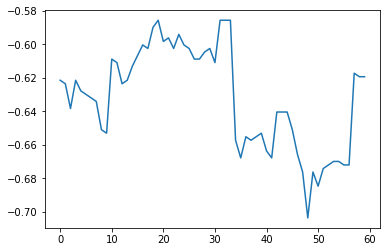

1
tensor([-0.1506,  0.1701,  0.4783, -0.1788,  0.7971,  1.1741, -1.5591, -1.9122,
        -1.6637])


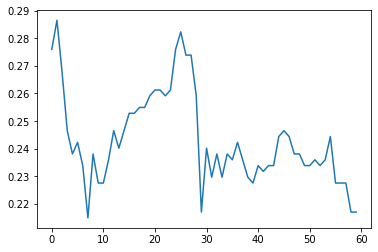

2
tensor([-0.0516,  0.3996,  0.2918,  0.2779,  0.4950,  1.4232,  0.4207,  0.0870,
         0.2578])


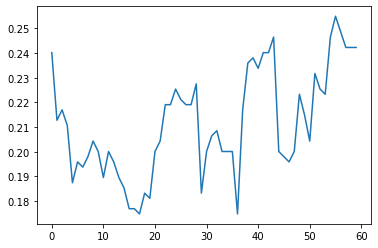

3
tensor([-0.4820,  0.0696, -0.4106,  0.2564, -0.1923,  0.3318,  0.3158, -0.0107,
         1.5487])


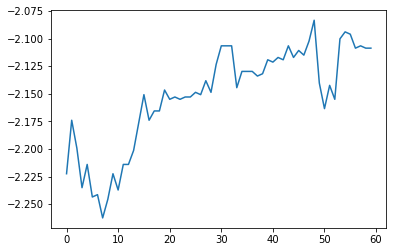

4
tensor([ 0.1502, -0.2131,  0.1726, -0.1498,  0.3346,  1.1168, -1.0917, -0.1514,
         1.2328])


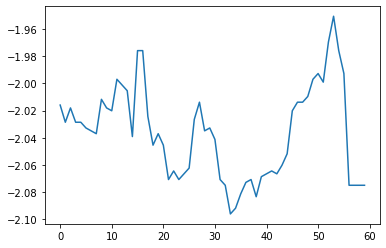

5
tensor([-0.1454, -0.0375, -0.3413, -0.6286, -0.2243,  0.6979,  0.0635, -0.1234,
         0.9908])


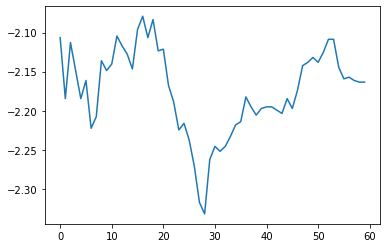

6
tensor([-0.1639,  0.0803,  0.2831, -0.5406, -0.1185,  0.3040,  0.1980,  0.3770,
         1.3332])


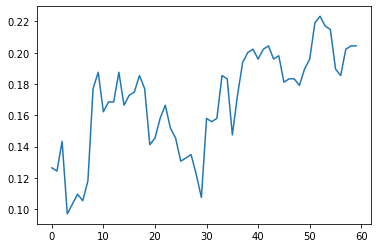

7
tensor([ -1.9197,  -0.0938,   2.9506,   2.1932,  -1.5675,  -5.1320,  -9.3817,
        -24.5215, -19.4880])


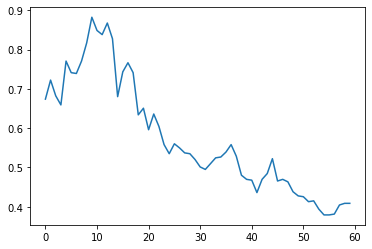

8
tensor([ 0.3863,  0.4075,  0.0969, -0.0962, -0.2166, -0.1177, -0.1765,  1.2254,
         2.4923])


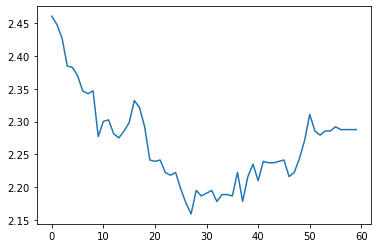

9
tensor([-0.5673, -0.4633, -0.0862,  0.2053,  0.7178, -1.7220, -4.5071, -5.5063,
        -2.2604])


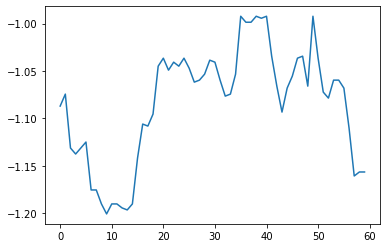

In [12]:
import matplotlib.pyplot as plt

for day in range(10):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:]).unsqueeze(0).cuda()
    test_futures = torch.tensor(fx['validation']['future'][day][:]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][21*60:22*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][21*60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
        print((pred.cpu() * 100))
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

0
tensor([ 0.,  0.,  0.,  0.,  0.,  1., -1., -1.,  0.])


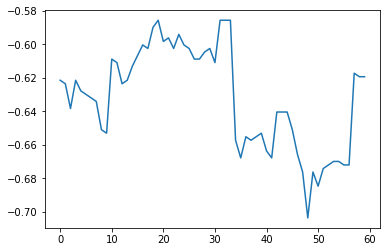

1
tensor([-0.,  0.,  0., -0.,  1.,  1., -2., -2., -2.])


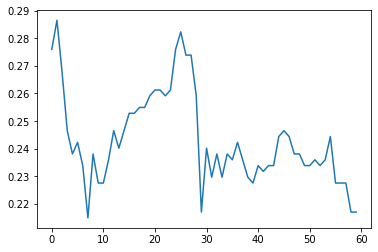

In [13]:
import matplotlib.pyplot as plt

for day in range(2):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:21*60 + 1]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][21*60:22*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][-1]
        
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
#         plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [14]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [15]:
(soft_profit.sum(axis = (1, 2)) < 0).mean()

0.22972972972972974

In [16]:
soft_profit.sum(axis = (1, 2)).std()

0.022248972

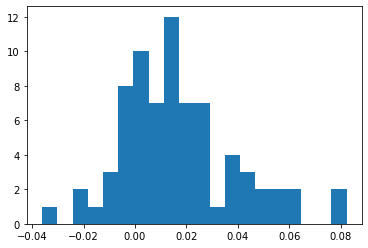

In [17]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)
plt.show()

In [27]:
# full trade percent on 24 hours
(((np.abs(soft_trade) > .2) & (np.abs(soft_trade) < 10)).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20., 14.,  2.])

In [19]:
# full trade accuracy on 24 hours
np.nanmean(np.where(((np.abs(soft_trade) > .2) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-19-f6be64cbd057>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(((np.abs(soft_trade) > .2) & (np.abs(soft_trade) < 10)), soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.6214357 , 0.60622915, 0.49518731])

In [25]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-25-e15bc04a1bb7>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan, 8.759946e-05, 5.286497e-05, 9.359053e-06],
      dtype=float32)

In [21]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .3).mean(axis = (0, 1))

array([0.00217718, 0.00628754, 0.00839902, 0.01072635, 0.01503378,
       0.01871246, 0.01641329, 0.00670983, 0.00306869])

In [23]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit > 0, np.nan), axis = (0, 1))

array([0.30826833, 0.4141882 , 0.46907994, 0.49762188, 0.5442541 ,
       0.56684406, 0.57175888, 0.57772081, 0.56079665])

In [24]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([9.3517876e-05, 1.1040257e-04, 1.2627446e-04, 1.3709566e-04,
       1.4370347e-04, 1.5203208e-04, 1.7406879e-04, 2.0122110e-04,
       2.4339784e-04], dtype=float32)

In [25]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-7.33010820e-05, -8.14286104e-05, -8.72624005e-05, -9.02208776e-05,
       -9.90652115e-05, -1.06105064e-04, -1.28709653e-04, -1.66588317e-04,
       -1.84737873e-04], dtype=float32)

In [21]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

## SGConv Experiments

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, 20 tanh * sigmoid gates soft trade

# log returns/growth maximization!! max loss set at .9
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000100,0.001790,-12.8106,-0.1986,4.3747,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000100,0.001048,-10.5499,-0.3165,2.2888,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000200,-0.000380,8.4592,0.2033,3.4070,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000200,0.000600,-6.6723,-0.2818,1.5611,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,0.000100,0.000333,-2.9658,-0.1108,1.7134,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,0.000100,-0.000373,6.4694,0.3229,2.4752,0.,nan,nan,0.,nan,nan,0.0021,65.,3.3329
1400,0.000100,0.000510,-2.1375,-0.0397,4.1186,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,0.000100,0.000169,-1.5814,-0.1516,1.8135,0.,nan,nan,0.,nan,nan,0.0028,29.6296,0.8997
1800,0.000000,0.000546,-4.9588,-0.1696,2.8135,0.,nan,nan,0.,nan,nan,0.0319,54.902,0.9591
2000,0.000000,-0.000016,3.3412,0.0845,3.484,0.,nan,nan,0.,nan,nan,0.0010,40.,1.9040


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

TrainOutput(global_step=8806, training_loss=-0.0002884957696402764, metrics={'train_runtime': 2556.5022, 'train_samples_per_second': 13.778, 'train_steps_per_second': 3.445, 'total_flos': 0.0, 'train_loss': -0.0002884957696402764, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, tanh traade signal

# log returns/growth maximization!! max loss set at .9
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.001900,nan,-50.2649,-0.1982,17.7463,3.8723,44.0531,0.8104,7.6037,48.2838,0.9804,14.4377,48.8362,0.9981
400,0.000600,nan,16.2712,0.1120,29.9043,15.3818,49.3214,1.0249,9.8238,49.6625,1.046,22.8937,48.6587,1.0075
600,0.000300,nan,68.1588,0.2475,16.8074,4.9977,53.9599,1.1348,3.9588,50.3029,1.0509,14.5153,50.3060,0.9900
800,0.000200,nan,66.7728,0.315,10.8613,2.1168,57.5144,1.4254,2.0385,58.4604,1.1653,10.4057,48.7048,0.9673
1000,-0.000400,nan,-3.6597,-0.0069,24.3455,14.9289,49.9686,1.0066,3.3614,47.2190,0.8424,10.4601,49.2479,1.0073
1200,0.000000,nan,44.3292,0.1421,21.3817,9.9382,50.6783,1.0726,4.1765,48.9689,0.9770,15.2404,49.2317,1.0395
1400,0.000000,nan,-131.9233,-0.3595,45.1507,24.3936,46.7317,0.9711,27.2575,48.4017,0.9304,25.1872,48.8315,0.9459
1600,0.000500,nan,-14.5568,-0.2222,14.9160,5.4450,47.3497,1.0237,4.0152,49.6897,0.9881,8.9324,49.3235,0.9292
1800,0.000800,nan,4.8399,0.1222,5.6987,0.1602,49.8698,0.9914,1.0181,51.2597,1.1481,2.4941,46.9752,1.1139
2000,0.000600,nan,-7.0336,-0.0712,6.1823,0.2118,45.1502,0.6244,1.1586,47.4125,1.0865,3.0895,46.0783,1.0206


<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()


TrainOutput(global_step=8806, training_loss=0.00020877963093063107, metrics={'train_runtime': 2550.6212, 'train_samples_per_second': 13.81, 'train_steps_per_second': 3.452, 'total_flos': 0.0, 'train_loss': 0.00020877963093063107, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, ELU softmax dot linspace trading (only 3 levels
# max grad norm set high to 10

# log returns/growth maximization!! max loss set at .9
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000500,nan,-6.5165,-0.0893,7.1115,0.,nan,nan,0.,nan,nan,1.4449,49.5345,1.0374
400,0.000600,0.001687,-13.6863,-0.2596,3.9192,0.,nan,nan,0.,nan,nan,0.2414,52.6134,1.1742
600,0.000400,-0.000075,8.8419,0.1445,5.7460,0.,nan,nan,0.,nan,nan,0.2781,48.5189,0.9295
800,0.000400,0.001103,-10.3386,-0.3399,2.9717,0.,nan,nan,0.,nan,nan,0.0859,40.4126,0.8896
1000,0.000100,0.000237,-1.252,-0.0518,2.7929,0.,nan,nan,0.0010,50.,1.5554,0.5213,46.5493,0.8477
1200,0.000100,-0.000306,6.5947,0.2243,2.5422,0.,nan,nan,0.,nan,nan,0.0111,48.1132,1.5865
1400,0.000100,0.000562,-5.5699,-0.2831,1.9354,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,0.000100,0.000122,-1.2820,-0.2254,0.874,0.,nan,nan,0.,nan,nan,0.0001,0.,nan
1800,-0.000000,0.000163,-0.8080,-0.0398,1.5396,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,0.000100,nan,1.2973,0.0340,5.7915,0.,nan,nan,5.6385,49.0337,0.9681,0.4867,50.0428,1.0331


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

TrainOutput(global_step=8806, training_loss=5.4471653772262314e-05, metrics={'train_runtime': 2688.6928, 'train_samples_per_second': 13.1, 'train_steps_per_second': 3.275, 'total_flos': 0.0, 'train_loss': 5.4471653772262314e-05, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 5e-5, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, ELU softmax dot linspace trading
# max grad norm set high to 10

# log returns/growth maximization!! max loss set at .9
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000100,0.000443,-4.2560,-0.1792,1.6095,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000000,0.000423,-4.0579,-0.1524,1.6947,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000100,-0.000526,11.4561,0.2455,3.3634,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000100,0.000259,-2.7117,-0.1767,1.0392,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,0.000100,0.000232,-1.5299,-0.0486,2.1264,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,0.000000,-0.000442,8.1161,0.2911,2.3929,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,0.000100,0.000499,-3.6647,-0.1115,2.3461,0.,nan,nan,0.,nan,nan,0.5278,53.2003,1.1289
1600,0.000100,0.000117,-0.9433,-0.0800,1.0972,0.,nan,nan,0.,nan,nan,0.1712,56.2728,1.0691
1800,0.000000,0.000350,-3.4583,-0.1764,1.6912,0.,nan,nan,0.,nan,nan,0.0246,66.5254,1.3163
2000,-0.000000,-0.000058,2.9785,0.0960,2.8445,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

TrainOutput(global_step=8806, training_loss=-5.3674497966212036e-05, metrics={'train_runtime': 2776.267, 'train_samples_per_second': 12.687, 'train_steps_per_second': 3.172, 'total_flos': 0.0, 'train_loss': -5.3674497966212036e-05, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, ELU softmax dot linspace trading

# log returns/growth maximization!! max loss set at .9
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.000000,0.001629,-12.3636,-0.2136,3.9602,0.,nan,nan,0.,nan,nan,0.,nan,nan
400,0.000100,0.000780,-8.0062,-0.2717,1.9235,0.,nan,nan,0.,nan,nan,0.,nan,nan
600,0.000100,-0.000304,7.0514,0.1803,3.2615,0.,nan,nan,0.,nan,nan,0.,nan,nan
800,0.000200,0.000567,-6.0703,-0.2228,1.5946,0.,nan,nan,0.,nan,nan,0.,nan,nan
1000,0.000200,0.000296,-2.3148,-0.0824,1.8364,0.,nan,nan,0.,nan,nan,0.,nan,nan
1200,0.000100,-0.000290,5.8476,0.2329,2.1919,0.,nan,nan,0.,nan,nan,0.,nan,nan
1400,0.000100,0.000701,-4.5006,-0.1004,3.5757,0.,nan,nan,0.,nan,nan,0.,nan,nan
1600,0.000100,0.000107,-1.0238,-0.1068,1.2206,0.,nan,nan,0.,nan,nan,0.,nan,nan
1800,0.000000,0.000389,-3.6754,-0.1631,2.32,0.,nan,nan,0.,nan,nan,0.,nan,nan
2000,0.000000,0.000251,-0.2754,-0.0066,3.3551,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

TrainOutput(global_step=8806, training_loss=-0.0002859434244352918, metrics={'train_runtime': 2634.0374, 'train_samples_per_second': 13.372, 'train_steps_per_second': 3.343, 'total_flos': 0.0, 'train_loss': -0.0002859434244352918, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, ELU softmax dot linspace trading

# mean weighted profit maximization, profit is 2x
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.004900,0.056758,-0.0316,-0.1623,5.2945,0.,nan,nan,0.,nan,nan,3.6761,46.0502,0.8619
400,-0.061300,-0.031766,-0.0402,-0.1005,6.881,0.7065,45.0856,0.7265,5.5893,48.1084,0.9904,4.0592,46.0454,0.8733
600,-0.061700,-0.051968,-0.0285,-0.0435,12.4229,6.0084,49.036,1.0189,5.3470,43.282,0.8875,5.9637,48.2621,1.0531
800,-0.082800,-0.020899,-0.0557,-0.0512,21.3705,17.5639,47.4030,0.9608,3.0645,48.2579,0.9773,2.6739,47.7656,1.0104
1000,-0.205500,-0.119867,-0.0433,-0.068,9.5024,7.2425,47.4114,0.9293,1.9337,46.3737,0.951,1.1942,46.7563,0.8985
1200,-0.199500,-0.171199,-0.0376,-0.0534,9.1170,6.7072,48.3902,0.9375,1.9020,45.4416,0.9316,1.3871,47.8915,0.9988
1400,-0.222000,-0.337203,0.0221,0.0794,2.7147,1.4583,51.8876,1.1484,0.5493,59.814,1.0247,0.5149,53.0984,1.0205
1600,-0.264000,-0.119955,-0.0707,-0.0922,12.1804,10.3181,47.3852,0.9388,0.7771,43.8347,1.0514,0.6494,44.5408,0.9030
1800,-0.191000,-0.171998,-0.0268,-0.0768,2.235,1.4985,46.5173,0.8114,0.2113,51.3820,0.6903,0.2259,49.5845,0.8551
2000,-0.299100,-0.149980,0.0039,0.07,0.8932,0.4513,55.8919,1.0261,0.1403,59.8068,0.6172,0.1445,55.6999,0.6716


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

TrainOutput(global_step=8806, training_loss=-0.3180327581839482, metrics={'train_runtime': 2621.8698, 'train_samples_per_second': 13.434, 'train_steps_per_second': 3.359, 'total_flos': 0.0, 'train_loss': -0.3180327581839482, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, ELU softmax dot linspace trading

# mean weighted profit maximization
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.003100,0.022964,-0.0344,-0.242,4.6667,0.,nan,nan,0.,nan,nan,2.7539,43.4402,0.801
400,-0.018300,0.004436,-0.0381,-0.0634,12.7231,0.,nan,nan,9.6539,46.5313,0.9838,14.8498,48.2404,1.0000
600,-0.042500,-0.133983,0.225,0.3912,8.9314,2.4802,57.7987,1.5276,4.4863,56.4184,1.2674,3.6210,55.5821,1.0371
800,-0.035800,-0.069043,0.0921,0.2649,12.7656,0.,nan,nan,0.9227,53.1246,1.2844,27.8835,51.5422,1.1155
1000,-0.008200,-0.081245,0.1470,0.3481,19.8265,0.5764,56.4942,1.2282,21.8812,51.7825,1.1117,14.0742,52.1481,1.1216
1200,-0.105400,-0.102595,0.0596,0.4267,1.9875,0.1179,81.3439,1.6192,0.2396,76.3272,1.3596,0.3274,70.1592,1.6459
1400,-0.079200,-0.208934,0.1327,0.4172,2.6652,1.0508,66.0250,1.6321,0.6856,60.6692,1.4409,0.6407,58.6981,1.3290
1600,-0.102300,-0.160771,0.1020,0.3722,2.0410,1.2550,62.1386,1.5175,0.3542,59.2287,1.3728,0.2623,60.2544,1.2273
1800,-0.074100,0.007796,-0.0021,-0.0308,2.3033,0.,nan,nan,0.,nan,nan,0.0001,0.,nan
2000,-0.095400,-0.128699,0.0431,0.4293,1.36,0.1567,76.7132,1.4359,0.1299,71.9904,1.5227,0.126,60.5960,1.8194


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

TrainOutput(global_step=8806, training_loss=-0.13377225811227517, metrics={'train_runtime': 2651.2045, 'train_samples_per_second': 13.286, 'train_steps_per_second': 3.322, 'total_flos': 0.0, 'train_loss': -0.13377225811227517, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, softmax dot linspace trading

# mean weighted profit maximization with .1 eps term
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,-0.002500,0.018898,0.095,0.2441,10.7305,0.,nan,nan,2.7734,57.8201,1.2201,10.0572,51.1140,1.0997
400,-0.009900,0.002291,0.0309,0.0183,38.2346,35.3922,49.3567,1.0177,5.1465,48.2546,0.9232,3.5344,47.159,0.97
600,-0.022400,0.007690,0.0553,0.0340,35.7756,30.6279,49.7682,1.0238,9.0416,47.8463,1.0169,3.5492,48.3577,0.9909
800,-0.010700,0.006608,0.0397,0.0271,37.9506,30.5796,49.5204,1.0089,14.8299,48.7284,1.0280,1.5299,46.4558,1.0661
1000,-0.037500,0.001676,0.0268,0.0165,42.6243,39.8810,49.2087,1.0176,9.8763,48.0785,1.0258,1.5785,45.3098,0.9750
1200,-0.021600,0.006572,0.0632,0.0383,42.7214,41.2734,49.1997,1.0302,5.6322,47.6664,1.0040,0.5768,46.6377,0.8191
1400,-0.022200,0.015560,0.1244,0.0809,34.5855,32.5444,49.5537,1.0598,4.8179,48.827,0.9477,1.0644,49.9902,1.0181
1600,-0.034600,0.000676,0.0193,0.0213,19.2497,17.7933,47.6316,1.0457,1.9854,52.8491,1.1147,2.0852,52.1902,1.1470
1800,-0.027900,-0.011544,-0.011,-0.0138,15.7480,14.8964,47.7496,1.0219,1.5307,50.6403,1.0584,1.3124,50.588,1.1054
2000,-0.034100,0.015422,0.13,0.1006,26.9628,27.0493,50.1176,1.0528,0.9565,48.8499,1.0147,0.8280,48.5203,0.9703


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


TrainOutput(global_step=8806, training_loss=-0.037139024943377306, metrics={'train_runtime': 2759.1859, 'train_samples_per_second': 12.766, 'train_steps_per_second': 3.192, 'total_flos': 0.0, 'train_loss': -0.037139024943377306, 'epoch': 1.0})

In [ ]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, softmax dot linspace trading

# raw standardized trade loss (summed per day per timeframe), .2 eps on loss and .1 eps on gain
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.064900,2.094477,-0.0972,-0.1883,31.1838,16.6145,47.5348,0.9237,3.0085,49.4576,0.9671,38.1306,48.977,1.0308
400,2.003800,2.069953,-0.0307,-0.0194,45.0778,40.8324,49.1278,0.985,14.2911,49.9770,0.9757,1.1533,53.6208,1.0897
600,1.970200,1.938346,0.2446,0.1766,37.9645,15.0615,51.5099,1.0892,32.05,50.3462,1.0508,22.851,50.1656,0.9587
800,2.028700,2.085721,-0.0822,-0.1513,56.8776,44.1831,48.1951,0.9638,22.0368,49.762,1.056,11.0659,49.7993,1.028
1000,2.006900,2.085723,-0.0822,-0.1514,56.875,44.1831,48.1951,0.9638,22.0368,49.762,1.056,11.0659,49.7993,1.028
1200,2.014400,1.871011,0.2608,0.2561,44.2482,30.671,51.1309,1.0612,10.3737,50.8654,1.0351,31.6646,49.7701,1.0189
1400,2.022400,1.857298,0.2788,0.2373,44.6326,28.7983,51.1682,1.0391,16.0691,51.6524,1.0684,34.4274,49.7579,1.0348
1600,2.002500,1.959510,0.2548,0.1191,77.5279,73.9884,50.2561,1.01,12.3403,51.5919,1.0535,9.4951,51.7691,1.0196
1800,2.034100,1.960901,0.2476,0.1163,76.8421,72.373,50.1530,1.0123,13.3839,52.0961,1.0291,9.2919,52.0912,1.0046
2000,1.958200,1.876423,0.2763,0.2388,64.3007,57.2847,51.1035,1.0059,13.9439,51.8022,1.0304,19.6974,50.6093,1.0159


In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, softmax dot linspace trading

# raw standardized trade loss (summed per day per timeframe), .1 eps on loss and gain
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.033200,1.061788,-0.0921,-0.1691,33.2258,14.1796,47.4887,0.9689,19.9089,48.2491,0.9532,23.0451,48.8964,0.9851
400,1.001400,1.033652,-0.0599,-0.0389,49.8571,48.391,49.1783,0.9858,7.1038,49.0577,1.0523,2.4408,44.6429,0.6922
600,0.982000,1.019378,0.0094,0.0065,33.371,29.1168,48.5181,0.9807,6.9268,49.6816,0.9803,4.8062,53.6654,1.2100
800,1.016000,1.018464,0.0140,0.0122,42.7766,36.3388,48.9682,0.9714,10.0748,50.6029,0.9879,9.1265,51.0962,1.0827
1000,0.948300,1.021248,-0.0224,-0.0195,41.0152,38.9449,49.028,0.9691,7.2282,49.6112,0.9960,6.7866,50.1736,1.0038
1200,0.967200,1.021454,-0.0164,-0.0197,28.2867,23.5652,48.8372,0.9707,8.5,49.5572,0.9864,5.6931,49.1584,0.981
1400,0.964400,1.089075,-0.2105,-0.2401,47.2775,30.0936,47.4994,0.9291,25.7876,48.2813,0.9243,17.8422,48.9475,1.0029
1600,0.975500,1.037372,-0.1759,-0.2189,55.0716,45.8987,49.7393,0.9339,19.9115,49.1257,0.8986,7.3492,47.0163,0.8136
1800,0.947200,1.001286,-0.0606,-0.1073,44.1866,35.0205,50.5272,0.9464,17.7309,50.3781,0.9330,6.5695,48.5858,0.8684
2000,0.930100,1.010391,-0.0692,-0.1005,36.4278,27.5615,50.4214,0.9314,15.5924,50.1047,0.9276,5.5653,49.422,0.9672


TrainOutput(global_step=8806, training_loss=0.9106597498062657, metrics={'train_runtime': 2857.4944, 'train_samples_per_second': 12.327, 'train_steps_per_second': 3.082, 'total_flos': 0.0, 'train_loss': 0.9106597498062657, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, softmax dot linspace trading

# scaled and clamped standardized  trade loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.000000,0.001562,-0.077,-0.2126,11.9255,0.,nan,nan,0.,nan,nan,19.399,47.3560,0.8902
400,0.000200,0.000189,-0.0044,-0.0364,4.6084,0.,nan,nan,0.,nan,nan,1.6729,46.5158,1.0603
600,0.000200,-0.000237,0.0841,0.2879,9.2772,0.,nan,nan,0.0167,57.5,0.9165,7.3834,57.4806,1.2241
800,0.000200,-0.000025,0.0097,0.1285,3.3144,0.,nan,nan,0.,nan,nan,0.8483,46.1529,0.9499
1000,0.000700,0.000392,0.0267,0.0757,9.1746,0.0161,39.6104,1.1976,1.4036,49.7586,1.1271,9.1389,50.1072,0.9856
1200,0.000400,-0.000214,0.0681,0.2544,8.4813,0.,nan,nan,0.0555,49.2481,1.2062,7.1983,51.6158,1.1711
1400,0.000100,0.000838,-0.0060,-0.0153,13.9181,0.,nan,nan,0.,nan,nan,24.7153,49.4878,0.9929
1600,0.000200,0.000360,-0.0106,-0.0937,7.8301,0.,nan,nan,0.,nan,nan,4.0075,47.2420,0.9808
1800,-0.000000,0.000523,-0.0065,-0.0369,11.2626,0.,nan,nan,0.7416,44.0101,0.9411,10.7672,50.9345,0.9896
2000,0.000000,0.000457,-0.0034,-0.0209,10.5258,0.,nan,nan,0.2778,42.7553,0.8156,2.5512,45.355,0.9757


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

TrainOutput(global_step=8806, training_loss=-0.00020663535170906036, metrics={'train_runtime': 3050.8781, 'train_samples_per_second': 11.545, 'train_steps_per_second': 2.886, 'total_flos': 0.0, 'train_loss': -0.00020663535170906036, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# conv embedding with kernel size 10, softmax dot linspace trading

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.003600,2.157054,-0.0223,-0.1137,5.6086,0.,nan,nan,0.,nan,nan,2.2701,46.4058,0.8825
400,1.886500,2.088481,-0.0409,-0.0773,9.6195,5.6939,48.0891,0.9524,3.0399,46.7792,0.9327,3.6022,46.2963,0.9627
600,1.932300,1.906072,0.0197,0.0488,8.5131,2.3125,52.9714,1.0778,3.72,46.3841,0.9820,5.3993,46.2621,0.9740
800,1.904300,1.931060,0.019,0.0406,9.6016,6.7339,48.4663,1.0017,2.1403,44.1976,0.983,2.1646,52.6326,1.1758
1000,2.546400,0.223821,0.0001,0.1239,0.0252,0.0127,54.9180,1.1655,0.0182,53.1429,0.9652,0.0092,50.,0.5
1200,0.130000,nan,nan,nan,nan,0.,nan,nan,0.,nan,nan,0.,nan,nan


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.
  'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of e

KeyboardInterrupt: 

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 4

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.005500,2.260033,-0.2119,-0.1664,41.1037,24.7753,48.2128,0.9163,19.4969,48.4108,0.9575,21.3900,49.7092,1.0138
400,1.958600,1.995216,0.0803,0.0442,69.0442,57.3000,49.6879,1.0046,20.8090,49.6034,0.9655,11.4261,49.7276,0.9752
600,1.963800,1.973849,0.2286,0.1176,64.8049,52.9492,49.9764,1.0470,18.6073,49.8114,1.0143,13.6242,48.1854,0.9696
800,1.996800,2.024575,0.0889,0.0596,56.856,40.9984,49.0568,1.0362,24.978,49.6604,1.0047,16.2908,49.1695,0.9902
1000,1.918600,1.967282,0.1337,0.0884,49.8819,34.6719,49.8402,1.0077,20.7901,50.8077,1.0064,17.2761,50.9111,1.0280
1200,1.910600,1.886967,0.3271,0.1884,65.6994,55.1968,51.215,1.0546,19.2911,49.2825,0.9376,11.8791,49.3149,0.9549
1400,1.973100,1.895158,0.0813,0.0534,58.5157,44.5464,50.7135,0.9623,22.0601,50.3169,0.9875,15.4889,50.444,1.0200
1600,1.914300,2.042216,-0.0554,-0.0391,60.9120,47.7727,49.5795,0.9611,17.6444,49.7397,0.9724,15.6958,49.9997,0.9671
1800,1.894200,2.046308,-0.141,-0.1292,47.3864,31.6486,49.1887,0.9112,16.5601,50.0856,0.9409,22.4016,50.1336,0.9876
2000,1.818900,1.935137,0.0747,0.0881,27.1472,12.7326,50.0422,1.0188,12.0005,50.4987,1.0316,16.7002,49.5973,0.9748


TrainOutput(global_step=8806, training_loss=1.558835234556473, metrics={'train_runtime': 2623.0921, 'train_samples_per_second': 13.428, 'train_steps_per_second': 3.357, 'total_flos': 0.0, 'train_loss': 1.558835234556473, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# No conv embedding, just linear -> gelu -> linear

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.991800,2.111296,-0.0916,-0.0865,37.7964,14.9784,50.0289,0.9732,30.0239,48.8708,0.9300,21.4699,48.8526,0.9564
400,1.961100,1.974542,0.2235,0.1120,86.2237,83.7446,49.7967,1.0297,8.5458,48.7433,0.9513,3.7140,50.0772,0.9574
600,1.965400,1.887537,0.3456,0.2585,74.1721,66.6291,50.4717,1.0386,13.5498,50.8134,0.9802,10.8085,50.3492,1.0003
800,1.977700,1.938891,0.2094,0.1730,97.4390,97.1214,49.5393,1.0272,1.1167,51.55,0.925,0.5988,51.9241,0.9777
1000,1.976800,1.981511,0.1648,0.1517,96.7398,96.3286,49.5916,1.016,1.5752,46.826,1.1220,0.7747,48.0081,1.0233
1200,1.974100,1.935635,0.1277,0.1186,91.7629,89.7383,50.1942,0.9846,5.1200,49.3432,0.9798,2.4094,49.2881,1.0072
1400,1.997300,1.967505,0.0680,0.0745,95.1054,94.0546,49.7128,0.9899,2.7418,48.572,0.9979,1.3686,48.3733,1.0072
1600,1.957300,1.975408,0.0658,0.0702,95.2018,94.2440,49.8401,0.9842,2.6611,49.1438,0.9951,1.3121,49.1815,0.9867
1800,1.965800,2.072864,-0.1271,-0.095,92.881,91.1622,49.0225,0.9735,4.2026,49.443,1.0041,2.1426,47.7759,0.9829
2000,1.959900,1.960785,0.1086,0.0880,90.4151,88.0174,49.9976,0.9872,5.3958,49.2734,1.0457,3.0461,49.6286,0.9823


TrainOutput(global_step=8806, training_loss=1.8171055103036022, metrics={'train_runtime': 2929.7362, 'train_samples_per_second': 12.023, 'train_steps_per_second': 3.006, 'total_flos': 0.0, 'train_loss': 1.8171055103036022, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored, only day prices
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# only an up-project for embedding

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.996800,2.075648,-0.1098,-0.1287,40.5403,16.1423,48.7762,0.9255,32.6571,49.7192,0.9459,24.0074,48.3315,0.9981
400,1.979600,1.971106,0.1179,0.0839,54.8734,38.4515,50.1531,1.0290,24.3677,50.2490,0.9348,18.0313,49.7644,0.9491
600,1.932000,1.932053,0.2276,0.1478,44.7086,30.1116,50.2247,1.0698,17.0453,50.1942,1.0079,18.5933,49.9750,0.9901
800,1.949400,1.955984,0.1854,0.1402,53.0323,37.3329,50.3325,1.0617,22.1178,48.5685,1.0035,19.3453,48.5563,0.9818
1000,1.871600,1.969229,0.1444,0.0933,55.1894,38.6032,50.057,1.0063,22.2883,50.5174,1.0189,22.2875,50.2887,0.9967
1200,1.882900,1.917511,0.2286,0.1441,49.5608,35.9597,50.5556,1.0564,17.3085,50.5816,0.9592,18.0400,51.0638,0.9418
1400,1.922300,1.890293,0.1404,0.1078,45.5372,26.5836,51.0867,0.9916,24.9722,50.9384,0.9847,21.3459,50.4006,1.0152
1600,1.890300,1.978779,0.0438,0.0307,44.2926,31.4853,50.1111,0.9905,15.6948,50.1007,0.9626,14.9637,49.6516,0.954
1800,1.891200,2.045614,-0.1033,-0.1025,35.9557,18.3480,49.1001,0.9439,17.3673,49.2414,0.8835,23.8222,49.8170,0.9681
2000,1.842200,1.943087,0.1116,0.0989,33.1739,16.7502,50.7585,1.0259,16.8708,50.2052,1.0084,18.9239,49.5598,0.9713


TrainOutput(global_step=8806, training_loss=1.6501509962963457, metrics={'train_runtime': 3001.03, 'train_samples_per_second': 11.737, 'train_steps_per_second': 2.934, 'total_flos': 0.0, 'train_loss': 1.6501509962963457, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss, losses 2x (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,1.931200,1.926929,0.0520,0.1246,25.6956,2.7233,52.2015,1.0196,17.8804,50.6467,0.9908,34.5888,49.9466,1.0133
400,1.879100,1.890123,0.0842,0.1209,36.6114,14.7138,49.3165,0.9972,24.4749,50.4806,0.9753,26.7429,50.943,1.0198
600,1.730700,1.659309,0.2349,0.4443,19.8502,10.8074,53.6272,1.2617,5.6224,51.4753,1.0386,8.5016,49.8908,0.9994
800,1.617100,1.521395,0.3337,0.3548,29.7141,21.3043,54.0425,1.1447,7.1844,50.0501,0.9862,8.6662,48.6163,0.9462
1000,1.511700,1.304314,0.2701,0.3904,13.0267,7.9798,57.4919,1.1768,3.535,54.7106,0.9572,4.3138,52.5513,0.9480
1200,1.463900,1.327118,0.1898,0.3623,12.4044,7.5620,55.7713,1.1685,3.6159,50.3374,0.9847,3.8146,50.6424,0.9883
1400,1.436200,1.395933,0.2121,0.3324,16.9442,12.2026,52.8267,1.1691,3.7334,50.5348,1.0332,3.7505,51.4165,1.0371
1600,1.447000,1.452734,0.0248,0.1016,6.8664,3.6950,50.7097,0.9809,1.7609,47.3176,1.043,2.2978,50.5468,0.9641
1800,1.450800,1.370238,0.0894,0.4092,7.3327,3.8766,55.9229,1.2147,2.2341,50.0467,0.9963,2.3319,47.7419,0.9980
2000,1.445800,1.336127,0.0579,0.2298,8.4095,5.1978,52.2819,1.0553,2.3649,48.5185,1.0457,2.4887,49.7779,1.0324


TrainOutput(global_step=8804, training_loss=1.2161343785536824, metrics={'train_runtime': 2875.508, 'train_samples_per_second': 12.246, 'train_steps_per_second': 3.062, 'total_flos': 0.0, 'train_loss': 1.2161343785536824, 'epoch': 1.0})

In [7]:
# oanda data ONLY MAJORS past 2009, overnight labels ignored
# SGCONV transformer architecture (fixed linear)! lr of 2e-4, batch size 5,
# hidden size 320, 1 head, NO dropout, weight decay
# NO rotary embed, norm or residual on conv embed, kernel size of 5

# raw standardized trade loss (summed per day per timeframe)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,0.968200,0.947759,0.0501,0.1156,26.0528,4.3777,49.6784,1.053,16.7949,50.0875,1.0033,32.2314,49.3976,1.0166
400,0.934200,0.952670,0.0651,0.0901,36.5554,15.2807,48.8911,0.9586,23.9898,50.2851,0.9727,25.6584,51.1110,1.03
600,0.864400,0.819264,0.2321,0.4685,18.7678,10.0807,53.6958,1.2813,5.1913,52.5418,1.0114,7.7154,50.3473,0.9773
800,0.801500,0.721963,0.2942,0.3882,21.9927,13.7199,55.043,1.1637,5.8127,52.6208,1.0421,8.3941,48.9236,0.96
1000,0.756800,0.654370,0.3002,0.381,15.4652,10.2951,56.5114,1.1758,3.6271,52.6779,0.9861,4.8654,52.1935,0.9190
1200,0.730900,0.681203,0.1976,0.3889,13.0798,7.2069,56.0282,1.2104,3.8606,50.8008,1.04,4.702,51.0600,0.9603
1400,0.723200,0.646497,0.1886,0.3773,12.8167,8.6397,54.2265,1.2455,3.1383,49.4418,0.9981,3.6688,51.0473,0.9778
1600,0.723800,0.827965,0.001,0.0035,7.4842,4.1659,48.9525,0.9522,1.569,47.1988,0.8918,1.9683,50.6754,0.9726
1800,0.744000,0.756372,0.0556,0.3281,4.6308,1.8173,55.5454,1.1778,1.0443,52.5112,1.0336,1.7374,50.8822,1.0006
2000,0.729500,0.665394,0.0686,0.2741,6.6985,3.5642,53.2385,1.1463,2.1139,48.9913,1.0414,2.304,50.8056,1.0239


TrainOutput(global_step=8804, training_loss=0.6076698233354422, metrics={'train_runtime': 3418.1337, 'train_samples_per_second': 10.302, 'train_steps_per_second': 2.576, 'total_flos': 0.0, 'train_loss': 0.6076698233354422, 'epoch': 1.0})